## Exercise 4: Camera Calibration

These exercises will take you through:
**Direct linear transform (DLT)**, linear algorithm for camera calibration and
**checkerboard calibration**, and bundle adjustment from Zhang (2000). You should be able to perform camera calibration using both methods.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation

### Mathematical exercises: Direct linear transform (DLT)

In this section consider the 3D points

$$ Q_{ijk} = \begin{bmatrix} i \\ j \\ k \end{bmatrix}$$

where i = 0,1, j = 0,1, and k = 0,1. Consider also a camera with f = 1000 and a resolution of 1080 × 1920. Furthermore, the camera is transformed such that

$$ R = \begin{bmatrix} \sqrt{1/2} & -\sqrt{1/2} & 0 \\ \sqrt{1/2} & \sqrt{1/2} & 0 \\ 0 & 0 & 1  \end{bmatrix} , t= \begin{bmatrix} 0 & 0 & 10\end{bmatrix}.$$

- **Exercise 4.1**. Find **_P_** and the projections **_q_**.

<font color='darkblue'>  First, we need to find the camera matrix, which is:
<font color='darkblue'> 
$$ K = \begin{bmatrix} f & \beta f & \delta_x \\ 0 & \alpha f & \delta_y \\ 0 & 0 & 1 \end{bmatrix}$$

In [94]:
#Camera matrix
d= (np.array([1920,1080]))/2
K=np.array([[1000,0,d[0]],[0,1000,d[1]],[0,0,1]])
R=np.array([[np.sqrt(1/2),-np.sqrt(1/2),0],[np.sqrt(1/2),np.sqrt(1/2),0],[0,0,1]]) #rotation
t=np.transpose([0,0,10]) #translation
Cam=np.column_stack((R,t))
P=K@Cam

print('The projection matrix is P=')
print(np.round(P,2))

The projection matrix is P=
[[ 7.0711e+02 -7.0711e+02  9.6000e+02  9.6000e+03]
 [ 7.0711e+02  7.0711e+02  5.4000e+02  5.4000e+03]
 [ 0.0000e+00  0.0000e+00  1.0000e+00  1.0000e+01]]


In [3]:
i,j,k=[0,1],[0,1],[0,1]
Q=[0,0,0]
for a in i:
    for b in j:
        for c in k:
            p=[a,b,c]
            Q=np.vstack([Q, p])
Q=Q[1:]

def projectpoints(P,Q):
    [m,n]=np.shape(Q)
    cnt=np.ones(m)
    Q_ext=np.column_stack((Q,cnt))

    projection=P@Q_ext.T
    
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    
    q_ijk=np.column_stack((qx,qy))
    
    return q_ijk

In [4]:
q=projectpoints(P,Q)

print('The projections q_ijk are:')
print(np.round(q,2))

The projections q_ijk are:
[[ 960.    540.  ]
 [ 960.    540.  ]
 [ 889.29  610.71]
 [ 895.72  604.28]
 [1030.71  610.71]
 [1024.28  604.28]
 [ 960.    681.42]
 [ 960.    668.56]]


- **Exercise 4.2**. Using only **_Q_** and **_q_** estimate the projection matrix **_P_** with DLT. Do not normalize your points to begin with.

Use the estimated projection matrix to reproject the points **_Q_**. What is the reprojection error $\sqrt{\sum||q_{est} − q||^2}$? Does normalizing your points change the results?


In [5]:
def DLT(Q,q):
    B=np.zeros((1,12))
    for i in range(len(Q)):
        Xi=Q[i][0]
        Yi=Q[i][1]
        Zi=Q[i][2]
        x1=q[i][0]
        y1=q[i][1]
        B_i=np.array([[0,-Xi,Xi*y1,0,-Yi,Yi*y1,0,-Zi,Zi*y1,0,-1,y1],[Xi,0,-Xi*x1,Yi,0,-Yi*x1,Zi,0,-Zi*x1,1,0,-x1],
                      [-Xi*y1,Xi*x1,0,-Yi*y1,Yi*x1,0,-Zi*y1,Zi*x1,0,-y1,x1,0]])
        
        B=np.vstack([B, B_i])

    B=B[1:,:] 
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    
    #The parameters are in the last line of Vh and normalize them:
    P = vh[-1,:] / vh[-1,-1] 
    P_est=P.reshape((3,4),order='F')
    
    return P_est

In [6]:
P_est=DLT(Q,q)
print('The estimated projection matrix P with DLT is:')
print(P_est)

The estimated projection matrix P with DLT is:
[[ 7.07106781e+01 -7.07106781e+01  9.60000000e+01  9.60000000e+02]
 [ 7.07106781e+01  7.07106781e+01  5.40000000e+01  5.40000000e+02]
 [ 1.51950320e-13 -2.06086187e-13  1.00000000e-01  1.00000000e+00]]


In [7]:
#Reprojection of points Q with the estimated P
repro_q=projectpoints(P_est,Q)


In [8]:
def normalize2d_3d(p,d):
    x=np.array([p[:,0],np.ones(len(p))])
    y=np.array([p[:,1],np.ones(len(p))])

    mu_x= np.mean(p[:,0])
    mu_y= np.mean(p[:,1])
    
    std_x= np.std(p[:,0])
    std_y= np.std(p[:,1])
    
    #Tranformation matrix
    T_x= np.array([[1/std_x, -mu_x/std_x]])
    T_y= np.array([[1/std_y, -mu_y/std_y]])
    
    x_norm=(T_x@x).T
    y_norm=(T_y@y).T

    points_norm=np.column_stack((x_norm,y_norm))
    T_z=1
    
    if d==3:
        z=np.array([p[:,2],np.ones(len(p))])
        mu_z= np.mean(p[:,2])
        std_z= np.std(p[:,2])
        T_z= np.array([[1/std_z, -mu_z/std_z]])
        z_norm=(T_z@z).T
        points_norm=np.column_stack((points_norm,z_norm))
    
    return T_x,T_y,T_z,points_norm


def projectionError(ori_q,esti_q):
    Err_x=0
    Err_y=0
    for a in range(len(esti_q)):
        Err_x=Err_x+((ori_q[a][0]-esti_q[a][0])**2)
        Err_y=Err_y+((ori_q[a][1]-esti_q[a][1])**2)
        
    Err=np.sqrt(Err_x+Err_y)
    
    return Err

In [9]:
E=projectionError(q,repro_q)
print('The reprojection error without normalization is ',np.round(E,11))

#We apply a function to normalize the points before estimating P.
Tx1,Ty1,Tz1,q_norm=normalize2d_3d(q,2)
Tx2,Ty2,Tz2,Q_norm=normalize2d_3d(Q,3)

#We estimate projection matrix P with the initial normalized points. 
P_est_norm=DLT(Q_norm,q_norm)

#Reprojection of points Q with the estimated P
repro_q_norm=projectpoints(P_est_norm,Q_norm)

E_norm=projectionError(q_norm,repro_q_norm)
print('The reprojection error without normalization is ',np.round(E_norm,15))


The reprojection error without normalization is  6.6e-10
The reprojection error without normalization is  3e-15


<font color='darkblue'> The projection matrix and the reprojections are identical to the original within machine precision. The reprojection error on my system is approximately $10^{-11}$ without normalization and $10^{−14}$ with normalization.

### Programming exercises: Checkerboard calibration

Here we will prepare calibration with checkerboards. We do not yet have the ability to detect checkerboards, so for now we will define the points ourselves.


- **Exercise 4.3**. Define a function `checkerboard_points(n, m)` that returns the 3D points

$$ Q_{ij} = \begin{bmatrix} i-\frac{n-1}{2} \\ j-\frac{m-1}{2} \\ 0 \end{bmatrix},$$

where $i = 0,...,n−1$ and $j = 0,...,m−1$. The points should be returned as a 3xn·m matrix and their order does not matter. These points lie in the z = 0 plane by definition.



In [10]:
def checkerboard_points(n,m):
    M=np.array([[0],[0],[0]])
    for i in range(n):
        for j in range(m):
            Q=np.array([[i-((n-1)/2)],[j-((m-1)/2)],[0]])
            M=np.column_stack((M,Q))
    M=M[:,1:]
    
    return M #(3 x n·m)matrix

- **Exercise 4.4**. Let $Q_\Omega$ define a set of corners on a checkerboard. Then define three sets of checkerboard points $Q_a$, $Q_b$, and $Q_c$, where

$$Q_a= R(\frac{\pi}{10},0,0) Q_\Omega ,$$
$$Q_b= R(0,0,0) Q_\Omega ,$$
$$Q_c= R(-\frac{\pi}{10},0,0) Q_\Omega $$
where

$$ R(\theta_x,\theta_y,\theta_z) = \begin{bmatrix} cos(\theta_z) & -sin(\theta_z) & 0 \\ sin(\theta_z) & cos(\theta_z) & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} cos(\theta_y) & 0 & -sin(\theta_y)\\ 0 & 1 & 0 \\ sin(\theta_y) & 0 & cos(\theta_y) \end{bmatrix} \begin{bmatrix} 1 & 0 & 0\\ 0 & cos(\theta_x) & -sin(\theta_x) \\ 0 & sin(\theta_x) & cos(\theta_x) \end{bmatrix}$$

Recall that you can compute R with scipy as follows:

`from scipy.spatial.transform import Rotation`

`R = Rotation.from_euler('xyz', [θx, θy, θz]).as_matrix()`

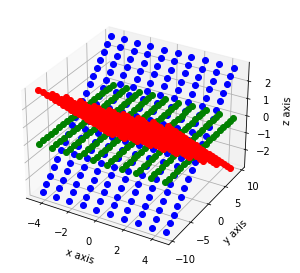

In [11]:
from scipy.spatial.transform import Rotation
Ra = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()

Q=checkerboard_points(10,20)
Qa=Ra@Q
Qb=Rb@Q
Qc=Rc@Q

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point1 in Qa.T:
    ax.plot(point1[0], point1[1], point1[2], 'bo')
for point2 in Qb.T:
    ax.plot(point2[0], point2[1], point2[2], 'go')
for point3 in Qc.T:
    ax.plot(point3[0], point3[1], point3[2], 'ro')


In [12]:
#We project all the checkerboard points to the image plane
q_a=projectpoints(P,Qa.T)
q_b=projectpoints(P,Qb.T)
q_c=projectpoints(P,Qc.T)

We will now go through the method outlined in Zhang’s method1 step by step.


- **Exercise 4.5**. Define a function `estimateHomographies(Q_omega, qs)` which takes the following input arguments:

    - $Q_\Omega$: an array original un-transformed checkerboard points in 3D, for example $Q_\Omega$.
    - $q_s$: a list of arrays, each element in the list containing $Q_\Omega$ projected to the image plane from
    different views, for example $q_s$ could be $[q_a,q_b,q_c].$
 
 
 
The function should return the homographies that map from $Q_\Omega$ to each of the entries in $q_s$.

The homographies should work as follows:
$$q= H Q'_\Omega$$

where $Q'_\Omega$ is $Q_\Omega$ without the z-coordinate, in homogeneous coordinates. Remember that we need
multiple orientations of checkerboards e.g. rotated and translated.

Use your function `hest` from week 2 to estimate the individual homographies. Your should return a list of homographies; one homography for each checkerboard orientation.
Test your function using $Q_\Omega$, $q_a$, $q_b$, and $q_c$. Check that the estimated homographies are correct with Equation above. 

In [13]:
def hest(p,q):
    B=np.zeros((1,9))
    for i in range(len(p)):
        x1=q[i][0]
        y1=q[i][1]
        x2=p[i][0]
        y2=p[i][1]
        B_i=np.array([[0,-x2,x2*y1,0,-y2,y1*y2,0,-1,y1],[x2,0,-x2*x1,y2,0,-y2*x1,1,0,-x1],
                      [-x2*y1,x2*x1,0,-y2*y1,y2*x1,0,-y1,x1,0]])
        
        B=np.vstack([B, B_i])
    
    B=B[1:,:] #12x9
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)

    H=vh[-1,:] / vh[-1,-1] 
    H_esti=H.reshape((3,3),order='F')
    
    return H_esti

In [14]:
def estimateHomographies(Q_omega, qs):
    H_set=[]
    for q in qs:
        H=hest(Q_omega.T,q)
        H_set.append(H)
    
    return H_set

In [15]:
qs=[q_a,q_b,q_c]
H_set=estimateHomographies(Q,qs)

Now, we check if the estimated homographies are correct, following: $q= H Q'_\Omega$


In [16]:
#We estimate if the homographies are correct. 
A=np.vstack([Q[0:2,:],np.ones(len(Q.T))])

q_a_esti=np.array([(H_set[0]@A)[0,:]/(H_set[0]@A)[2,:],(H_set[0]@A)[1,:]/(H_set[0]@A)[2,:]])
q_b_esti=np.array([(H_set[1]@A)[0,:]/(H_set[1]@A)[2,:],(H_set[1]@A)[1,:]/(H_set[1]@A)[2,:]])
q_c_esti=np.array([(H_set[2]@A)[0,:]/(H_set[2]@A)[2,:],(H_set[2]@A)[1,:]/(H_set[2]@A)[2,:]])

In [17]:
print('Example: An original q_a point is',q_a[0])
print('The corresponding q_a point from the estimated homographies is',q_a_esti.T[0])

Example: An original q_a point is [1413.9356833  -814.79299394]
The corresponding q_a point from the estimated homographies is [1413.9356833  -814.79299394]


<font color='darkblue'> We can conclude that our homographies are correct since the estimate $q_s$ are the same as the original ones, as presented with the example below. 

_Paper: Zhang, Zhengyou. "A flexible new technique for camera calibration." IEEE Transactions on pattern analysis and machine intelligence 22.11 (2000): 1330-1334._

- **Exercise 4.6**. Now, define a function `estimate_b(Hs)` that takes a list of homographies Hs and returns the vector **_b_** from _Equation 6_ in the paper. Use _Equations 8 and 9_ in the paper to form the matrix **_V_** . This is the coefficient matrix used to estimate **_b_** using SVD.

_Paper: Zhang, Zhengyou. "A flexible new technique for camera calibration." IEEE Transactions on pattern analysis and machine intelligence 22.11 (2000): 1330-1334._



Test your function with the homographies from previous exercise. See if you get the same result as by constructing $B_{true} = K^{−T}K^{−1}$, and converting this into $b_{true}$.


Is **_b_** a scaled version of **$b_{true}$**?

Suggestions for debugging: Check that $v_{11} · b_{true} = h^T_1 B_{true}h_1$


In [24]:
def v_if(i,j,h):
    i=i-1
    j=j-1
    v=np.array([h[i][0]*h[j][0],h[i][0]*h[j][1]+h[i][1]*h[j][0],h[i][1]*h[j][1],h[i][2]*h[j][0]+h[i][0]*h[j][2],h[i][2]*h[j][1]+h[i][1]*h[j][2],h[i][2]*h[j][2]]).T
    return v

In [96]:
def estimate_b(H_set):
    V=np.zeros((1,6))
    for Hs in H_set: 
        v12=v_if(1,2,Hs)
        v11_22=v_if(1,1,Hs)-v_if(2,2,Hs)
        v_i=np.vstack([v12, v11_22])
        V=np.vstack([V, v_i])
 
    
    V=V[1:,:] #2n x 6 matrix
    u,s,vh= np.linalg.svd(V,full_matrices=True, compute_uv=True)
    b=vh[-1,:] / vh[-1,-1]
    #B is symmetric, defined by a 6D vector
    b_esti=np.array([[b[0],b[1],b[3]],[b[1],b[2],b[4]],[b[3],b[4],b[5]]])
    
    return V,b,b_esti

In [97]:
V,b_vect,b_esti=estimate_b(H_set)
print('The estimated b from the homographies is:')
print(b_esti)
print(' ')
B_true= np.linalg.inv(K).T@np.linalg.inv(K)
print('B_true matrix is:')
print(B_true)

The estimated b from the homographies is:
[[ 1.21320000e+02  2.25358026e-12 -1.06066017e+01]
 [ 2.25358026e-12 -7.87464182e-13 -2.20921538e-13]
 [-1.06066017e+01 -2.20921538e-13  1.00000000e+00]]
 
B_true matrix is:
[[ 1.0000e-06  0.0000e+00 -9.6000e-04]
 [ 0.0000e+00  1.0000e-06 -5.4000e-04]
 [-9.6000e-04 -5.4000e-04  2.2132e+00]]


- **Exercise 4.7**. Next ,define a function `estimateIntrisics(Hs)` that takes a list of homographies **_Hs_** and returns a camera matrix **_K_**. Use your `estimate_b` from the previous exercise. From **_b_**, estimate the camera matrix **_K_** (they use A in the paper). Find the solution in Appendix B from the paper: 
$B = \lambda A^{−T} A $

$$ A = \begin{bmatrix} \alpha & \gamma & u_0 \\ 0 & \beta & v_0 \\ 0 & 0 & 1  \end{bmatrix}$$

Our camera matrix was: 
$$ K = \begin{bmatrix} 1000 & 0 & 960 \\ 0 & 1000 & 540 \\ 0 & 0 & 1  \end{bmatrix}$$




_Solution:_
$$v_0=(B_{12}B_{13}-B_{11}B_{23})/(B_{11}B_{22}-B_{12}^2) $$
$$\lambda=B_{33}-[B_{13}^2+ v_0(B_{12}B_{13}-B_{11}B_{23})]/B_{11} $$
$$\alpha= \sqrt{\lambda/B_{11}} $$
$$\beta= \sqrt{\lambda B_{11}/(B_{11}B_{22}-B_{12}^2)}$$
$$\gamma=-B_{12}\alpha^2\beta/\lambda $$
$$u_0=\gamma v_0/\beta-B_{13}\alpha^2/\lambda $$


Test your function with the homographies from Exercise 4.5. Do you get the original camera matrix?

In [179]:
def estimateIntrisics(H_set):
    
    V,b_v,b_esti=estimate_b(H_set)
    B11,B12,B22,B13,B23,B33=b_v[0],b_v[1],b_v[2],b_v[3],b_v[4],b_v[5]
    
    v_0= (B12*B13-B11*B23)/(B11*B22-(B12**2))
    lam= B33 - (B13**2+v_0*(B12*B13-B11*B23))/B11
    alpha= np.sqrt(lam/B11)
    beta= np.sqrt(lam*B11/(B11*B22-(B12**2)))
    gamma= (-B12*alpha**2*beta)/lam
    u_0=((gamma*v_0)/beta) - ((B13*alpha**2)/lam)
    
    K_esti=np.array([[alpha,gamma,u_0],[0,beta,v_0],[0,0,1]])
    
    return K_esti,lam

In [180]:
K_esti,lam=estimateIntrisics(H_set)

/var/folders/10/xzk2l09d3_g6x6v7c5tmyw7m0000gn/T/ipykernel_66428/1929068456.py:9: RuntimeWarning: invalid value encountered in sqrt
  beta= np.sqrt(lam*B11/(B11*B22-(B12**2)))


- **Exercise 4.8**. Now, define a function `Rs, ts = estimateExtrinsics(K, Hs)` that takes the camera matrix **_K_** and the homographies **_Hs_** and returns the rotations **_Rs_** and translations **_ts_** of each checkerboard. Use the formulas given in the paper but you do not need to bother with Appendix C — we can live with the error.

What kind of rotations do you get, and are they valid?
Join the functions to make a larger function `K, Rs, ts = calibratecamera(qs, Q)` that finds the camera intrinsics and extrinsics from the checkerboard correspondences q and Q.

In [133]:
def estimateExtrinsics(K,lam, H_set):
    R_set=[]
    t_set=[]
    for Hs in H_set:
        r1=lam*np.linalg.inv(K)@Hs[:,0]
        r2=lam*np.linalg.inv(K)@Hs[:,1]
        r3=np.cross(r1,r2)
        t=lam*np.linalg.inv(K)@Hs[:,2]
        
        R=np.column_stack((r1,r2,r3))
        
        R_set.append(R)
        t_set.append(t)

    return R_set,t_set

In [134]:
R_set,t_set=estimateExtrinsics(K,lam,H_set)

In [145]:
def calibratecamera(qs, Q):
    
    Q_omega=checkerboard_points(10,20)
    H_set=estimateHomographies(Q_omega,qs)
    
    V,b_vect,b_esti=estimate_b(H_set)
    
    K_esti,lam=estimateIntrisics(H_set)
    Rs,ts=estimateExtrinsics(K,lam,H_set)
 

    return K_esti,Rs,ts

In [146]:
qs=[q_a,q_b,q_c] #2D points
Q=[Qa,Qb,Qc] #3D points

K_esti,Rs,ts=calibratecamera(qs,Q)

/var/folders/10/xzk2l09d3_g6x6v7c5tmyw7m0000gn/T/ipykernel_66428/2043065906.py:9: RuntimeWarning: invalid value encountered in sqrt
  beta= np.sqrt(lam*B11/(B11*B22-(B12**2)))
